In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

Using TensorFlow backend.


In [5]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
# !python curate_db.py 

## Import and Curate Dataframe

In [2]:
all_dat = pd.read_csv('./curated.csv', index_col=0)

# sift out pwrs
all_dat = all_dat.loc[all_dat['reactor_type'] == 'PWR']  
all_dat = sklearn.utils.shuffle(all_dat)
# only get assemblies with enrichment bigger than 1.5 and bunrup higher than 10,000
all_dat = all_dat.loc[(all_dat['init_enr'] > 1.5) & (all_dat['bu'] > 10000)]

# separate training and testing set
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]


## Categorize Isotopes

In [7]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[5:]
print(iso_list)
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}

print(category)

['zr-95', 'zr-93', 'ra-226', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'pu-238', 'pu-239', 'np-237', 'nb-95', 'pa-231', 'pd-107', 'pm-147', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cm-248', 'cs-134', 'cs-135', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'am-241', 'am-242m', 'am-243', 'cf-251', 'cf-249', 'ag-108m', 'ag-110m', 'ac-227', 'cm-243', 'cm-242', 'c-14', 'ce-144', 'u-234', 'u-235', 'u-236', 'y-90', 'u-238', 'th-229', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126', 'th-232', 'th-230', 'u-232', 'u-233']
{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'cm-248',

## Define regression algorithms

- From Sklearn:
    - linear regression
    - bayesian ridge
    - huber regressor
    - ridge
    - lasso
    - random forest
- From Keras:
    - neural network

In [8]:
algorithms = {'lin_least_square': linear_model.LinearRegression,
              'bayesianridge': linear_model.BayesianRidge,
              'huberregressor': linear_model.HuberRegressor,
              'ridge': linear_model.Ridge,
              'lasso': linear_model.Lasso}
    
def linear_regression(algorithm, xtrain, ytrain, xtest, ytest):
    al = algorithm()
    model = al.fit(xtrain, ytrain)
    model_err = (ytest - model.predict(xtest))**2
    return model, model_err

def poly_regression(xtrain, ytrain, xtest, ytest, deg=2):
    poly = sklearn.preprocessing.PolynomialFeatures(degree=deg)
    x_ = poly.fit_transform(xtrain)
    predict_ = poly.fit_transform(xtest)
    
    # remove polynomial orders that isn't necessary (optional)
    
    model = linear_model.LinearRegression()
    model.fit(x_, ytrain)
    
    prediction = model.predict(predict_)
    model_err = (ytest - prediction)**2
    return model, model_err
    

def random_forest(xtrain, ytrain, xtest, ytest,
                  estimators=1000, state=42):    
    # Instantiate model with 1000 decision trees
    model = RandomForestRegressor(n_estimators = estimators, random_state = state)
    # Train the model on training data
    model.fit(xtrain, ytrain)
    model_err = (ytest - model.predict(xtest))**2
    return model, model_err



## Find best model for each isotope
Train model where:

**features**: burnup, enrichment

**target**: composition of isotope

Find model that predicts the isotopic composition with smallest squared error for each isotope

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


zr-95


No handles with labels found to put in legend.


poly3
9.483932595108546e-14


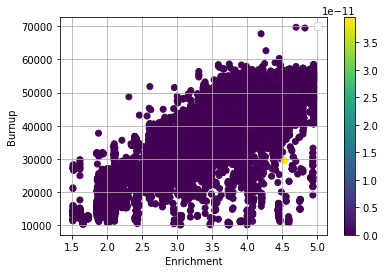

zr-93


No handles with labels found to put in legend.


poly3
3.3080166364185014e-11


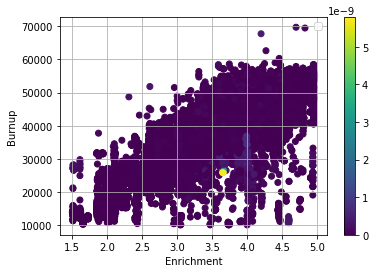

ra-226
Cant use  huberregressor


No handles with labels found to put in legend.


poly3
2.422515392572359e-27


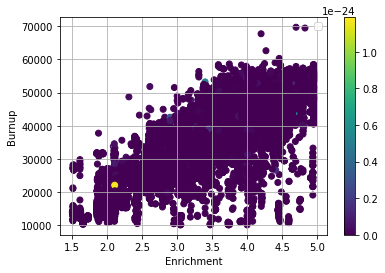

ru-103


No handles with labels found to put in legend.


poly3
2.898790398325171e-16


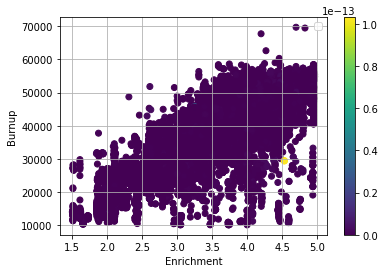

ru-106


No handles with labels found to put in legend.


poly3
2.4878816672483776e-10


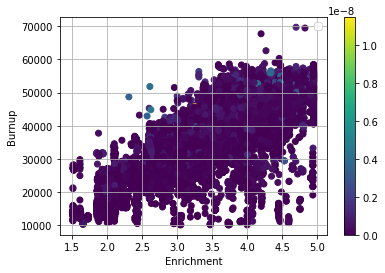

sb-124


No handles with labels found to put in legend.


poly4
3.2842111350921893e-20


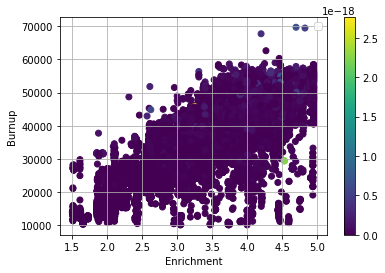

sb-125


No handles with labels found to put in legend.


poly3
1.4219434357127845e-12


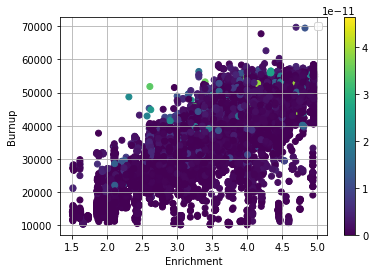

pu-238


No handles with labels found to put in legend.


poly4
8.53040567997756e-10


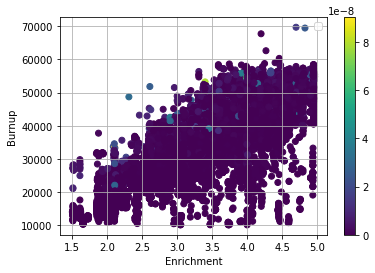

pu-239


No handles with labels found to put in legend.


random forest
1.588862777594009e-07


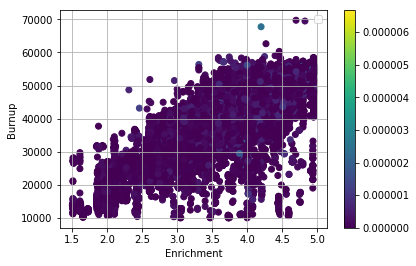

np-237


No handles with labels found to put in legend.


poly3
3.389087842698482e-10


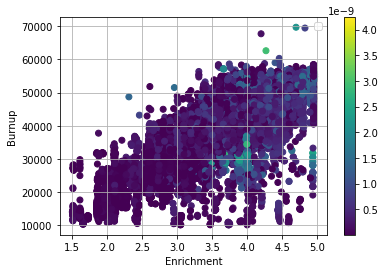

nb-95


No handles with labels found to put in legend.


poly3
1.3195655959944666e-13


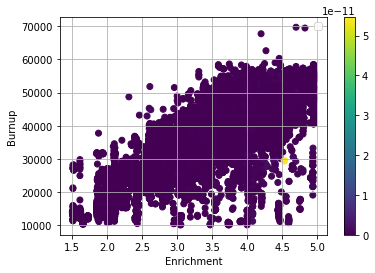

pa-231


No handles with labels found to put in legend.


poly4
4.491121704123717e-20


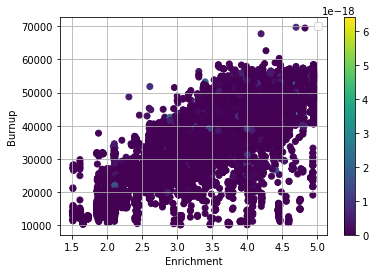

pd-107


No handles with labels found to put in legend.


poly3
1.2062204074521709e-11


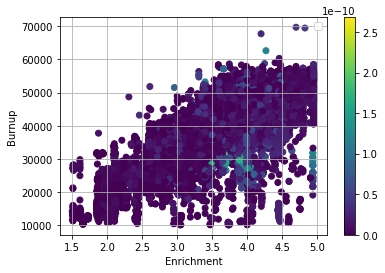

pm-147


No handles with labels found to put in legend.


poly3
2.0197800266391561e-10


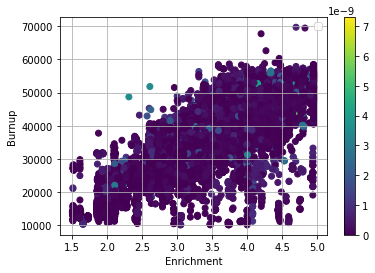

pu-240
poly3
4.577605754597608e-09


No handles with labels found to put in legend.


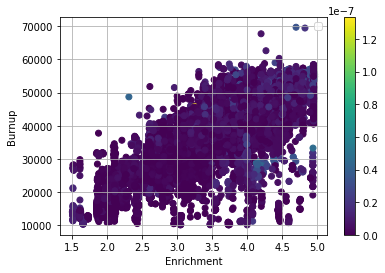

pu-241


No handles with labels found to put in legend.


poly3
9.365996609272243e-09


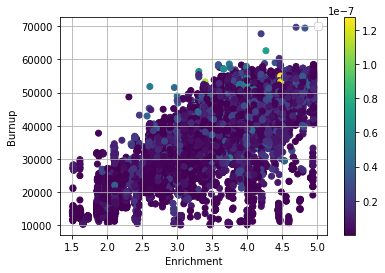

pu-244


No handles with labels found to put in legend.


poly4
4.949290413048708e-17


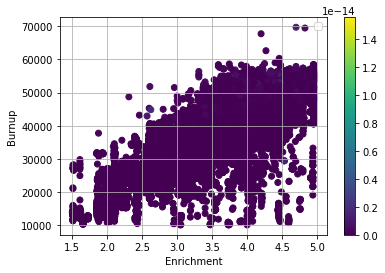

pu-242


No handles with labels found to put in legend.


poly3
2.0323980331739653e-10


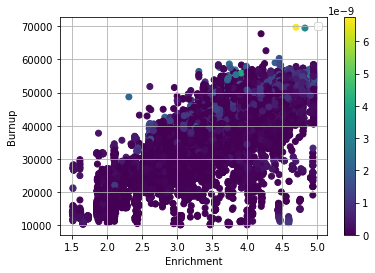

i-129


No handles with labels found to put in legend.


poly3
5.292287800144391e-12


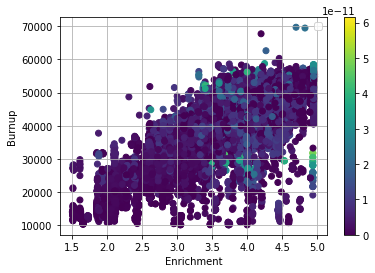

h-3


No handles with labels found to put in legend.


poly3
1.0916276686241063e-19


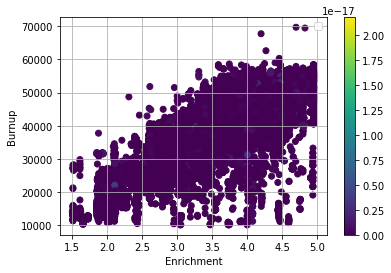

kr-85
poly4
9.918563304401602e-12


No handles with labels found to put in legend.


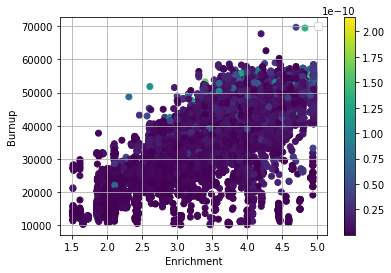

nb-94


No handles with labels found to put in legend.


poly3
3.666217308006192e-20


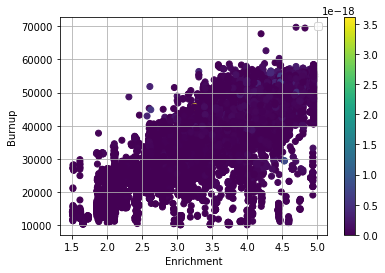

cm-248
poly5
2.4732105189921804e-20


No handles with labels found to put in legend.


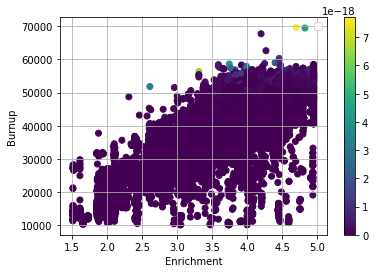

cs-134
poly4
1.3279419036888043e-10


No handles with labels found to put in legend.


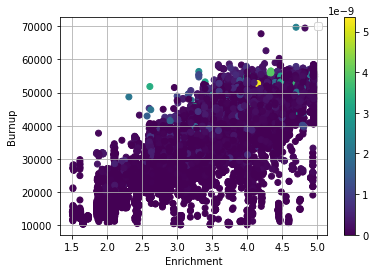

cs-135


No handles with labels found to put in legend.


poly3
7.567647557385338e-09


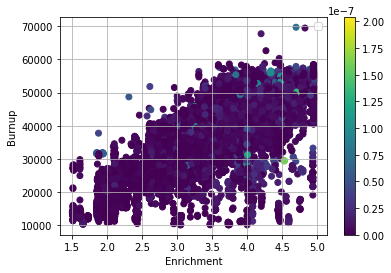

cm-245


No handles with labels found to put in legend.


poly5
6.287196033193988e-13


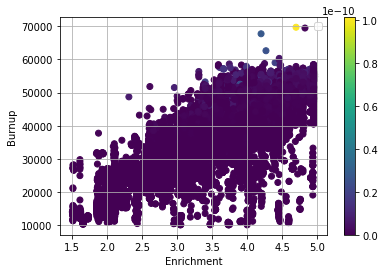

cm-244


No handles with labels found to put in legend.


poly4
9.455367089348347e-12


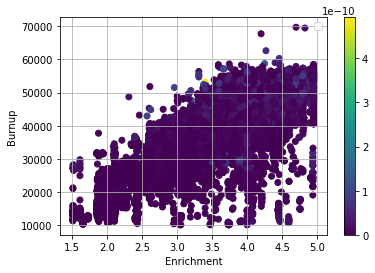

cm-246


No handles with labels found to put in legend.


poly5
2.1538932138615295e-15


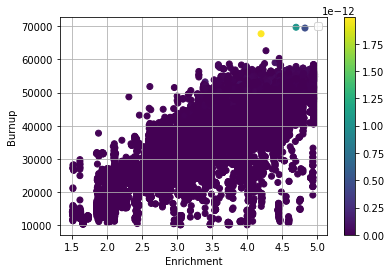

cm-247


No handles with labels found to put in legend.


poly5
2.1215387046437456e-18


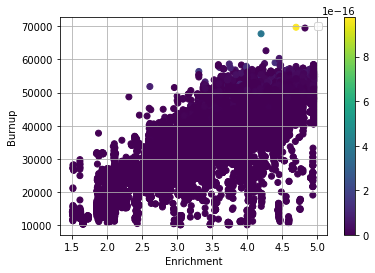

eu-152


No handles with labels found to put in legend.


poly3
6.273266589485539e-17


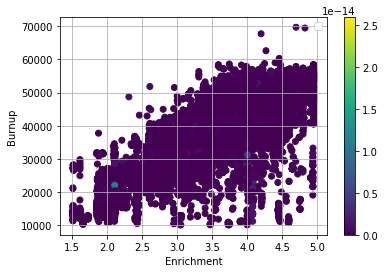

cs-137
poly3
7.297625479691621e-10


No handles with labels found to put in legend.


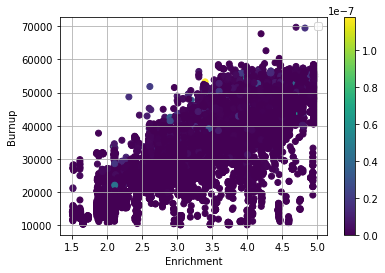

eu-154
poly4
2.9728106406321772e-12


No handles with labels found to put in legend.


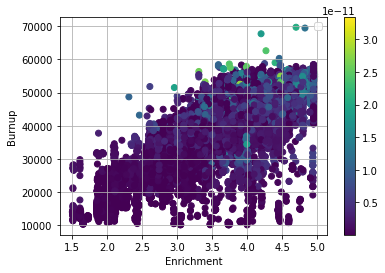

eu-155


No handles with labels found to put in legend.


poly3
2.601901573269327e-14


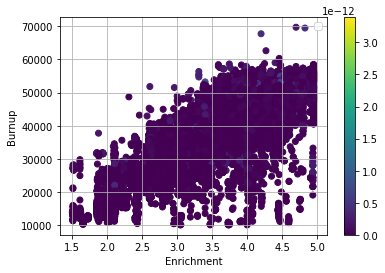

am-241


No handles with labels found to put in legend.


poly3
7.139387818150103e-10


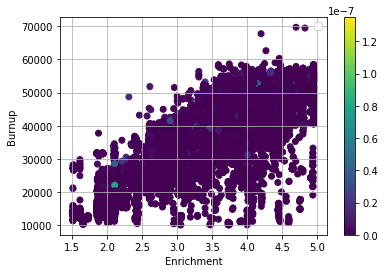

am-242m


No handles with labels found to put in legend.


poly4
2.5551725092075126e-13


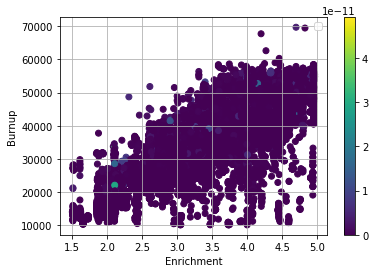

am-243


No handles with labels found to put in legend.


poly3
1.350389196980646e-11


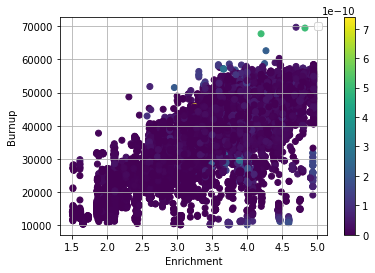

cf-251


No handles with labels found to put in legend.


poly5
5.171559279118537e-25


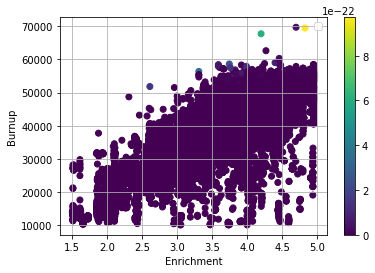

cf-249


No handles with labels found to put in legend.


poly5
8.365664984569259e-24


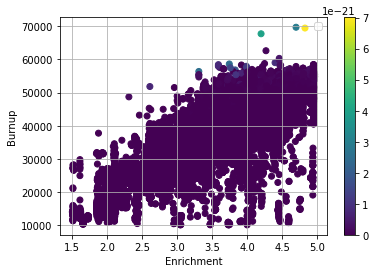

ag-108m


No handles with labels found to put in legend.


poly3
7.749495000181666e-23


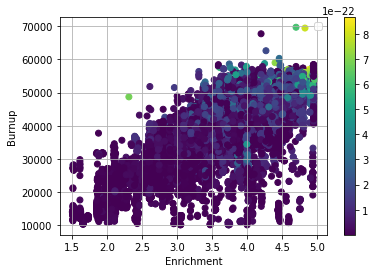

ag-110m
poly3
3.7020080236146766e-15


No handles with labels found to put in legend.


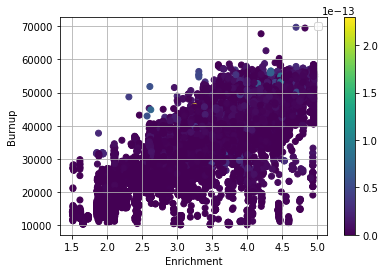

ac-227
Cant use  huberregressor


No handles with labels found to put in legend.


poly5
1.8579729213326493e-28


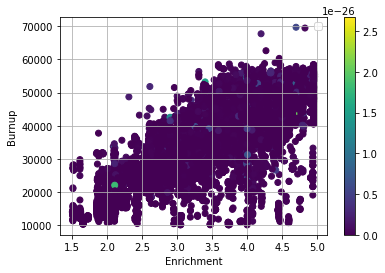

cm-243


No handles with labels found to put in legend.


poly3
5.900358440048807e-14


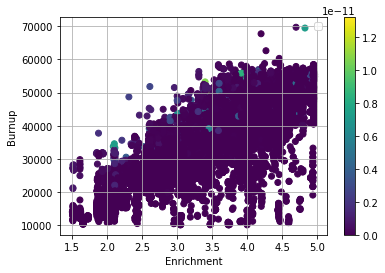

cm-242


No handles with labels found to put in legend.


poly3
2.7812997475652582e-12


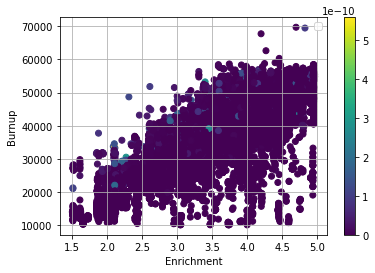

c-14


No handles with labels found to put in legend.


poly3
5.416109417489418e-16


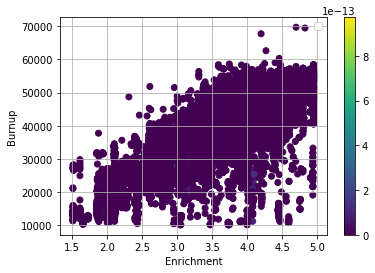

ce-144


No handles with labels found to put in legend.


poly5
9.911685176067268e-10


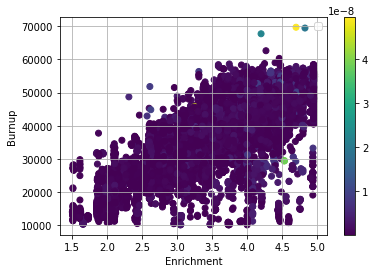

u-234


No handles with labels found to put in legend.


poly2
4.209274219711167e-12


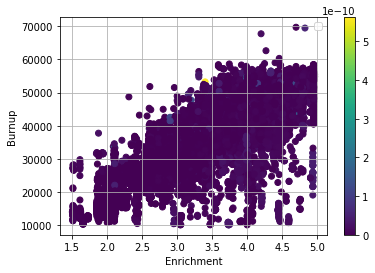

u-235


No handles with labels found to put in legend.


random forest
9.239033204023156e-08


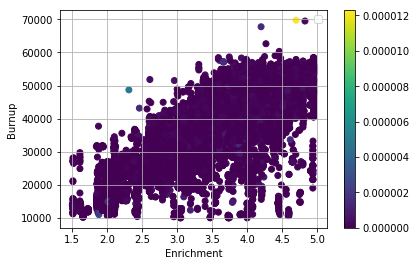

u-236
poly3
3.306680014217206e-10


No handles with labels found to put in legend.


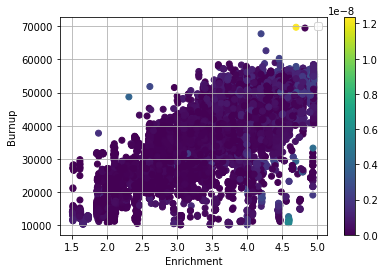

y-90


No handles with labels found to put in legend.


poly3
1.2016261493659812e-17


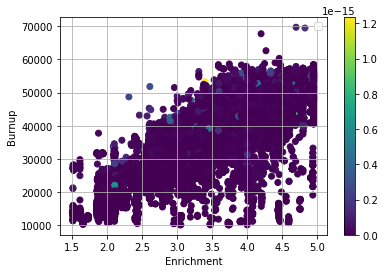

u-238


No handles with labels found to put in legend.


random forest
6.952734982311257e-07


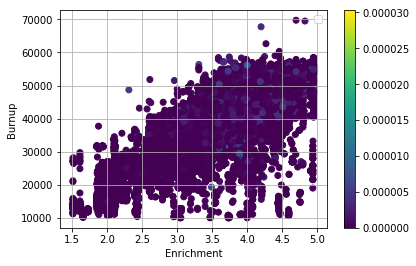

th-229
poly5
2.192133781643797e-24


No handles with labels found to put in legend.


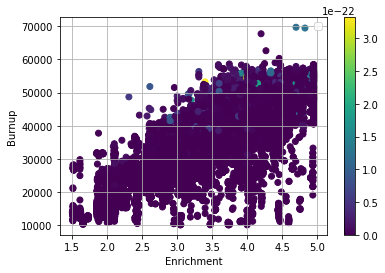

tc-99
poly3
1.948501038710526e-11


No handles with labels found to put in legend.


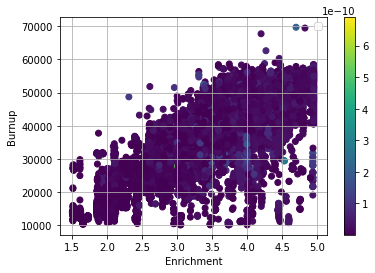

sm-151


No handles with labels found to put in legend.


poly4
1.073884443953835e-12


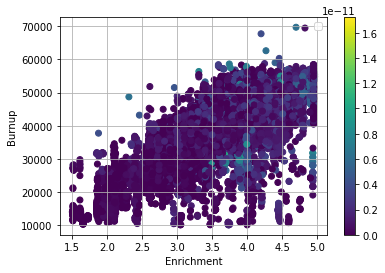

se-79


No handles with labels found to put in legend.


poly3
5.746864505598521e-17


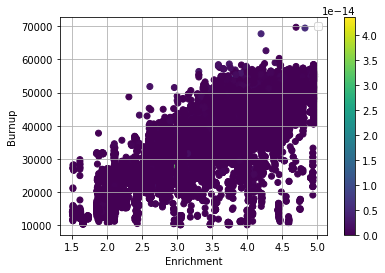

sr-90
poly3
1.867911307275308e-10


No handles with labels found to put in legend.


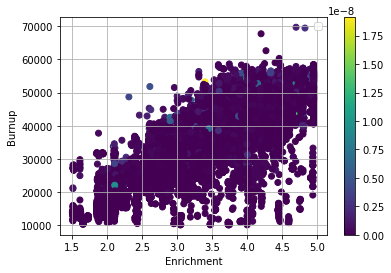

sn-126
poly3
6.259287073401946e-14


No handles with labels found to put in legend.


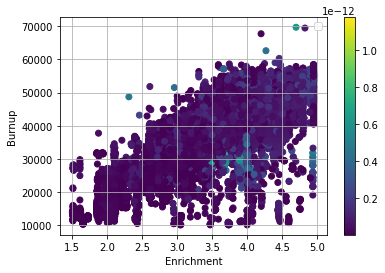

th-232


No handles with labels found to put in legend.


poly4
4.445874652284133e-20


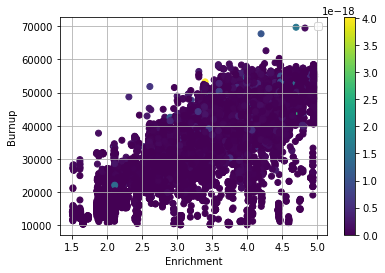

th-230


No handles with labels found to put in legend.


poly3
4.563852069167645e-19


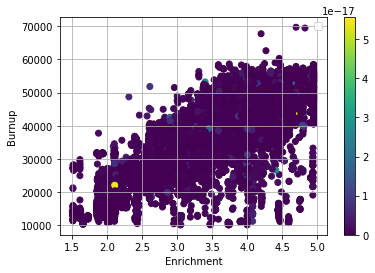

u-232


No handles with labels found to put in legend.


poly5
8.295996982083722e-20


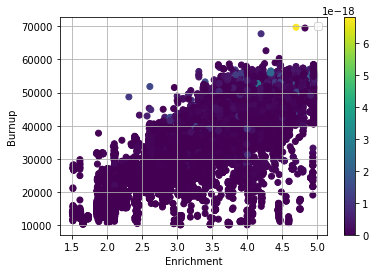

u-233


No handles with labels found to put in legend.


poly3
5.438387102440145e-20


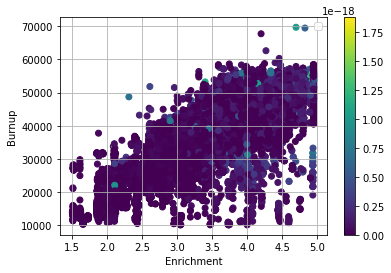

In [6]:
x_train = train_dat[['init_enr', 'bu']].as_matrix()
x_test = test_dat[['init_enr', 'bu']].as_matrix()
iso_err_dict = {}
alg_dict = {}
alg_str_dict = {}

for iso in iso_list:
    print(iso)
    err_dict = {}
    alg_buff = {}
    y_train = np.asarray(train_dat[iso])
    y_test = np.asarray(test_dat[iso])
    
    for key, val in algorithms.items():
        try:
            alg_buff[key], err_dict[key] = linear_regression(val, x_train, y_train, x_test, y_test)
        except:
            print('Cant use ', key)
    alg_buff['random forest'], err_dict['random forest'] = random_forest(x_train, y_train, x_test, y_test)
    alg_buff['poly2'], err_dict['poly2'] = poly_regression(x_train, y_train, x_test, y_test, deg=2)
    alg_buff['poly3'], err_dict['poly3'] = poly_regression(x_train, y_train, x_test, y_test, deg=3)
    alg_buff['poly4'], err_dict['poly4'] = poly_regression(x_train, y_train, x_test, y_test, deg=4)
    alg_buff['poly5'], err_dict['poly5'] = poly_regression(x_train, y_train, x_test, y_test, deg=5)

    
    mean_err_dict = {}
    for key, val in err_dict.items():
        mean_err_dict[key] = np.abs(np.mean(val))
    
    chosen_alg = min(mean_err_dict, key=mean_err_dict.get)
    print(chosen_alg)
    err = err_dict[chosen_alg]
    iso_err_dict[iso] = np.mean(err)
    alg_dict[iso] = alg_buff[chosen_alg]
    alg_dict[iso + '_alg'] = chosen_alg
    print(np.mean(err))
    
    plt.scatter(x_test[:,0], x_test[:,1], c=err)
    plt.xlabel('Enrichment')
    plt.ylabel('Burnup')
    plt.colorbar()
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()


## Two things:
- iso_err_dict
    - key: isotope
    - value: Mean error of model with test set
- alg_dict
    - key: isotope
    - value: tuple (algorithm name, fitted model object)

u-235
-0.0007544109514285055


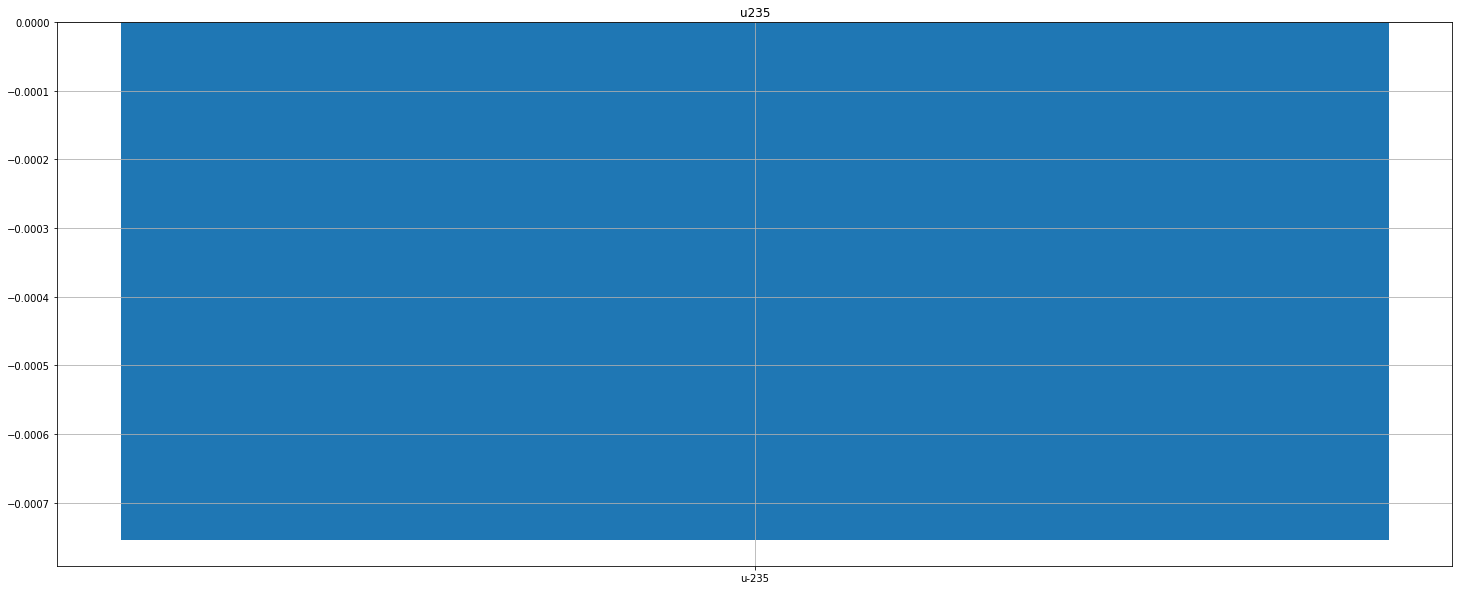

pu-239
-0.0017034196135666878
u-233
-0.0021644876668123914


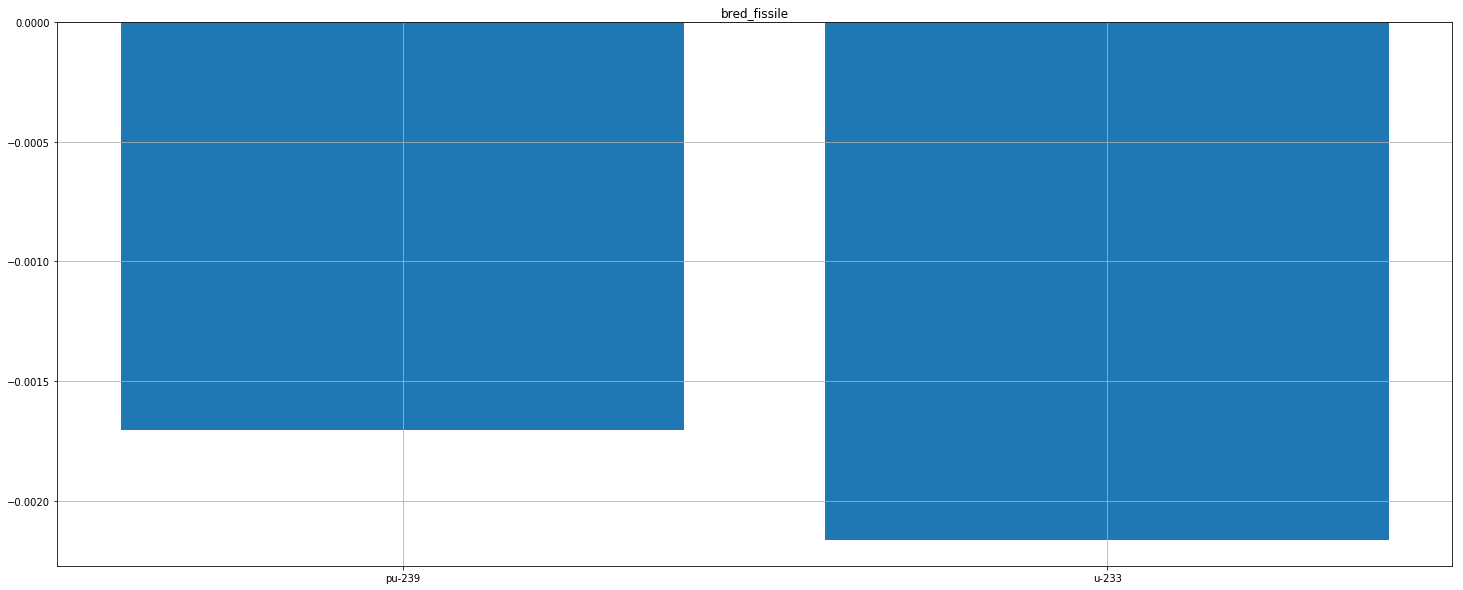

zr-95
-0.05699272835902731
zr-93
-0.00013708976488961864
ru-103
-0.05545801755411176
ru-106
-0.03199591567315248
sb-124
-0.03776407818835588
sb-125
-0.01567369027999097
nb-95
-0.05648254107494025
pd-107
0.00010935741382119186
pm-147
-0.010891676096429766
i-129
-0.00019468115490740186
h-3
-9.395190663885248e-05
kr-85
-0.010645099062752975
nb-94
-0.007796464400811093
cs-134
-0.010554075336597765
cs-135
-0.02130102203938427
eu-152
-0.10145141734026959
cs-137
-0.00037874322651226805
eu-154
-0.002334502404269514
eu-155
-0.00036000546143996875
ag-108m
-0.0012715816100144575
ag-110m
-0.10195748308990348
c-14
-0.01754719185521418
ce-144
-0.05670297909452999
y-90
-0.0005823435951766414
tc-99
-4.0271072338420804e-05
sm-151
-0.0037473566768459195
se-79
4.410542103014106e-06
sr-90
-0.0006478486247884631
sn-126
-9.631917463471666e-05


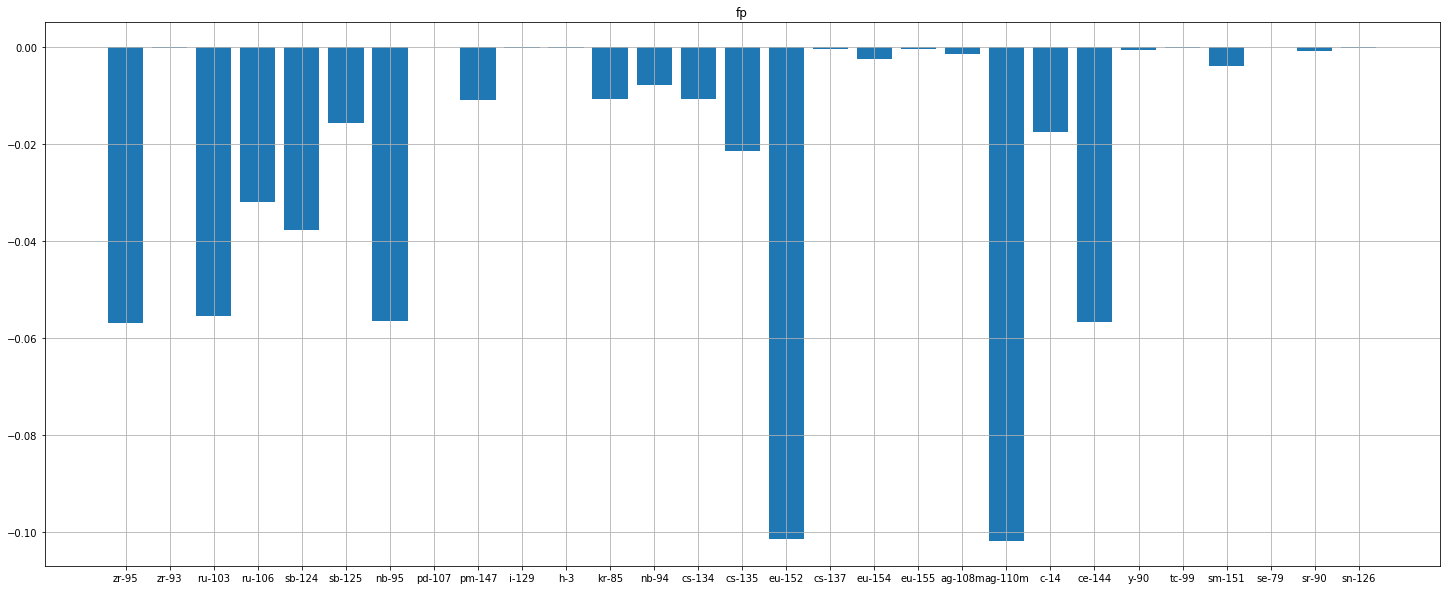

pu-238
-0.008687271795800344
np-237
-0.0009366959295061821
pu-240
-0.00048284056405823676
pu-241
-0.0033574520461457764
pu-244
-0.05224730695440252
pu-242
-0.002019964481663824
cm-248
58.76887127853317
cm-245
0.09941612619205074
cm-244
-0.038127860012949995
cm-246
0.6925920036281213
cm-247
6.076103088376654
am-241
-0.02247472376539893
am-243
-0.00620071351711913
cm-243
-0.039889110213157074
cm-242
-0.04563623833899611


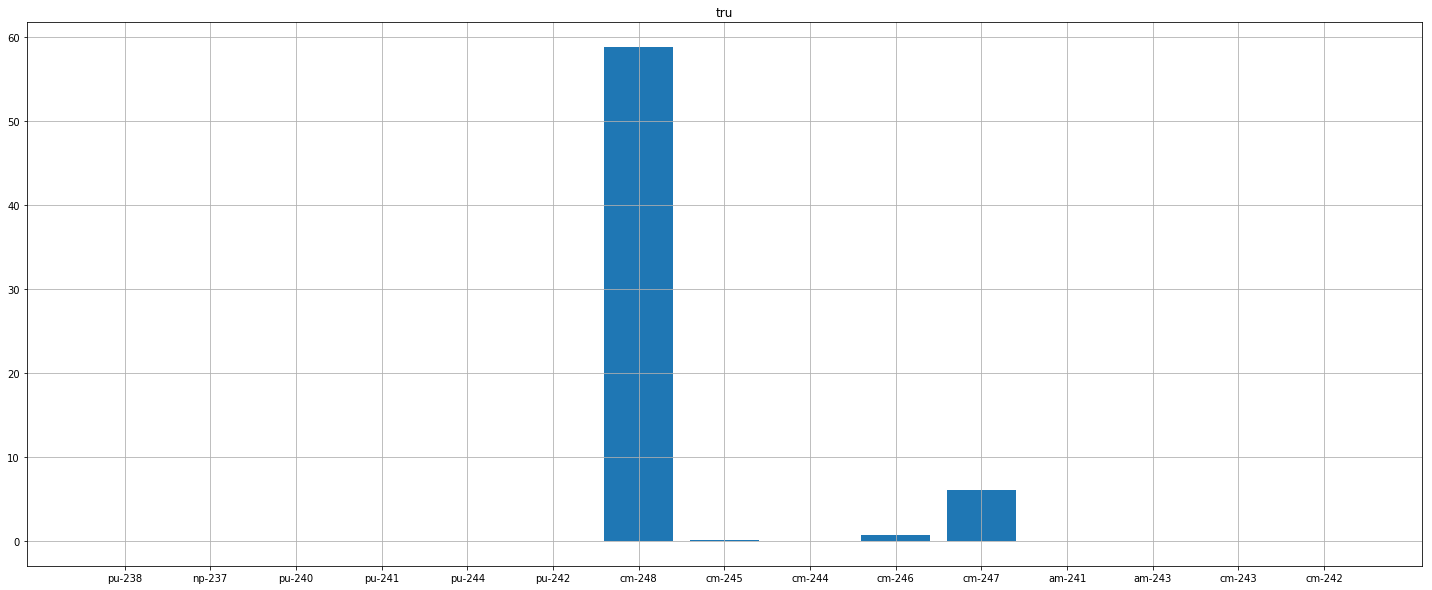

ra-226
-0.2997626090921326
pa-231
-0.08896827487328501
am-242m
-0.11751757914589026
cf-251
1891.7895223382861
cf-249
300.8152616372526
ac-227
-0.20154210266353983
u-234
-0.00011974676207029733
u-236
6.679391582381192e-05
u-238
-1.4005120356757415e-05
th-229
-0.2451572285633505
th-232
-0.001566736387256574
th-230
-0.060917367768877816
u-232
-0.023937528645318815


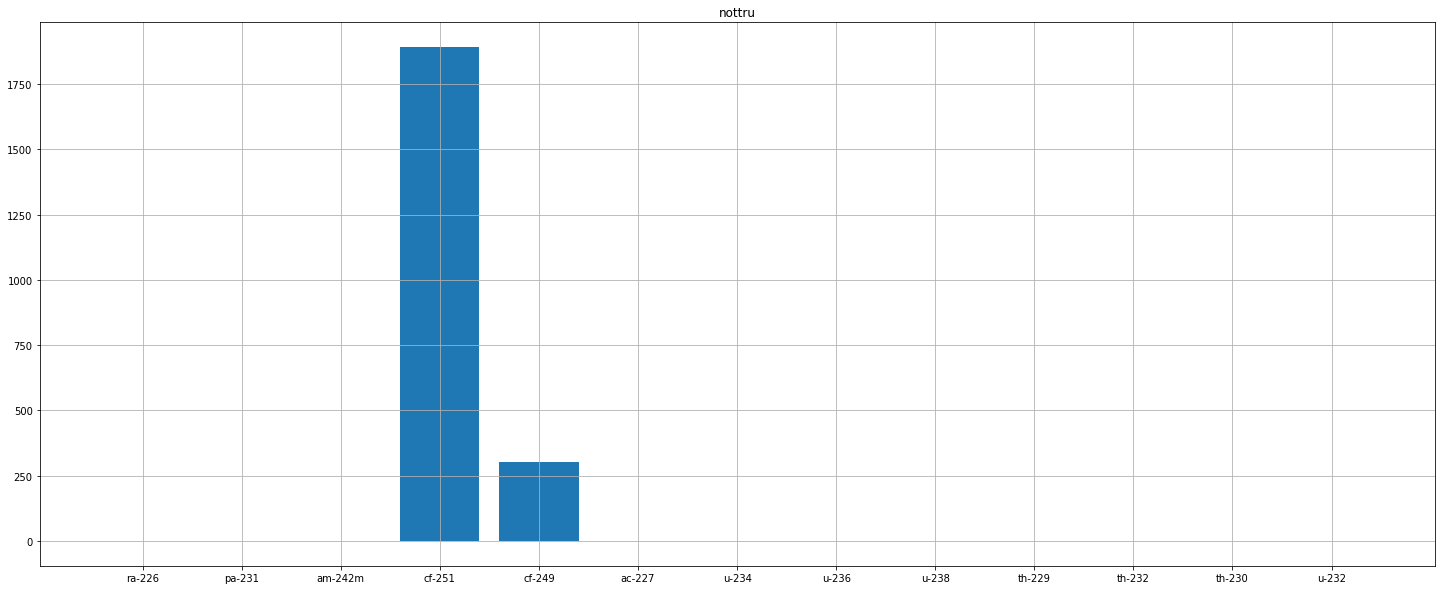

In [7]:
# use trained models to predict, and check percent error
for key, val in category.items():
    err_list = []
    for iso in val:
        y_test = np.asarray(test_dat[iso])
        print(iso)
        if any(i.isdigit() for i in alg_dict[iso + '_alg']):
            deg = get_a(alg_dict[iso + '_alg'])
            poly = sklearn.preprocessing.PolynomialFeatures(degree=deg)
            predicted = alg_dict[iso].predict(poly.fit_transform(x_test))
        else:
            predicted = alg_dict[iso].predict(x_test)
        err = (y_test - predicted) / y_test
        mean_err = np.mean(err)
        err_list.append(mean_err)
        print(mean_err)
    plt.figure(figsize=(25,10))
    plt.bar(val, err_list)
    plt.title(key)
    plt.grid()
    plt.show()
    plt.close()

## Pickle alg_dict to be used elsewhere

In [8]:
f = open('lin_dep.pkl', 'wb')
pickle.dump(alg_dict, f)
f.close()